In [ ]:
!nvidia-smi

In [2]:
# config
import torch
import torch.nn as nn

# hyperparameters
class Config:
    gpu_id = 0 if torch.cuda.is_available() else -1
    device = torch.device('cuda:0') # torch.device('cpu') 
    max_seq_len = 100
    train_ratio = .8
    valid_ratio = .1
    hidden_size = 512
    output_size = 1
    num_head = 8
    num_encoder = 12
    use_leakyrelu = True
    dropout_p = .1
    learning_rate = 0.001
    grad_acc = True
    grad_acc_iter = 8

    batch_size = 64
    n_epochs = 2
    
gpu_id = 0 if torch.cuda.is_available() else -1
device = torch.device('cuda:0') # torch.device('cpu') 
max_seq_len = 100
train_ratio = .8
valid_ratio = .1
hidden_size = 512
output_size = 1
num_head = 8
num_encoder = 12
use_leakyrelu = True
dropout_p = .1
learning_rate = 0.001
grad_acc = True
grad_acc_iter = 8

batch_size = 64
n_epochs = 2
    
config = Config()

# dataloader
from dataloaders.assist2009_pid_diff_loader import ASSIST2009_PID_DIFF
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from utils import pid_diff_collate_fn

# 1. get Dataset
dataset = ASSIST2009_PID_DIFF(config.max_seq_len, idx=0, config=config)
num_q = dataset.num_q
num_r = dataset.num_r
num_pid = dataset.num_pid
num_diff = dataset.num_diff
collate = pid_diff_collate_fn

# 2. split Dataset
train_size = int( len(dataset) * config.train_ratio * (1 - config.valid_ratio))
valid_size = int( len(dataset) * config.train_ratio * config.valid_ratio)
test_size = len(dataset) - (train_size + valid_size)

train_dataset = Subset(dataset, range( train_size ))
valid_dataset = Subset(dataset, range( train_size, train_size + valid_size ))
test_dataset = Subset(dataset, range( train_size + valid_size, train_size + valid_size + test_size ))

# 3. get DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size = config.batch_size,
    shuffle = True, # train_loader use shuffle
    collate_fn = collate
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size = config.batch_size,
    shuffle = False, # valid_loader don't use shuffle
    collate_fn = collate
)
test_loader = DataLoader(
    test_dataset,
    batch_size = config.batch_size,
    shuffle = False, # test_loader don't use shuffle
    collate_fn = collate
)

from models.monacobert_ctt import MonaCoBERT_CTT

model_monaco_ctt = MonaCoBERT_CTT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    num_diff=num_diff,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16, # TODO : 16 인데 실제로는 8 임, head_ratio 확인
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p,
).to(device)

model_monaco_ctt_path = '../model_records/0.8089741885505527_8_29_13_28_ctt_model.pth'

model_dict = torch.load(model_monaco_ctt_path)
model_monaco_ctt.load_state_dict(model_dict['model'])

In [5]:
from models.monacobert import MonaCoBERT

model_no_diff = MonaCoBERT(
    num_q=num_q,
    num_r=num_r,
    num_pid=num_pid,
    hidden_size=hidden_size,
    output_size=output_size,
    num_head=16,
    num_encoder=num_encoder,
    max_seq_len=max_seq_len,
    device=device,
    use_leakyrelu=use_leakyrelu,
    dropout_p=dropout_p
).to(device)

model_path = '../checkpoints/checkpoint.pt'
model_dict = torch.load(model_path, map_location = device)
model_no_diff.load_state_dict(model_dict)

<All keys matched successfully>

In [6]:
import torch
from copy import deepcopy

from torch.nn.functional import one_hot
from sklearn import metrics
import numpy as np
from tqdm import tqdm
from random import random, randint

from utils import EarlyStopping

# For Test MLM
# The last of seq will be changed to the <MASK>
def Mlm4BertTest(r_seqs, mask_seqs):
    #|r_seqs| = (bs, n)

    mlm_r_seqs = []
    mlm_idxs = []

    for r_seq, mask_seq in zip(r_seqs, mask_seqs):
        r_len = r_seq.size(0)

        real_r_seq = torch.masked_select(r_seq, mask_seq).cpu()
        real_r_seq_len = real_r_seq.size(0)

        # last index of real_r_seq
        mlm_idx = real_r_seq_len - 1
        # last index get a <MASK>, <MASK> is 2
        real_r_seq[mlm_idx] = 2

        pad_len = r_len - real_r_seq_len
        pad_seq = torch.full((1, pad_len), 3).squeeze(0) # <PAD> is 3
        pad_r_seq = torch.cat((real_r_seq, pad_seq), dim=-1)
        mlm_r_seqs.append(pad_r_seq)

        mlm_zeros = np.zeros(shape=(r_len, ))
        mlm_zeros[mlm_idx] = 1
        mlm_idxs.append(mlm_zeros)

    mlm_r_seqs = torch.stack(mlm_r_seqs)
    mlm_idxs = torch.BoolTensor(mlm_idxs)

    return mlm_r_seqs, mlm_idxs
    # |mlm_r_seqs| = (bs, n)
    # |mask_seqs| = (bs, n)

class Tester():
    def __init__(
        self, 
        model, 
        n_epochs, 
        device, 
        num_q, 
        crit, 
        max_seq_len, 
        grad_acc=False, 
        grad_acc_iter=4
        ):
        self.model = model.to(device)
        self.n_epochs = n_epochs
        self.device = device
        self.num_q = num_q
        self.crit = crit
        self.max_seq_len = max_seq_len
        self.grad_acc = grad_acc #gradient accumulation
        self.grad_acc_iter = grad_acc_iter
        
        # save the vis
        self.emb_idx = [] # q, r, pid, diff
        self.emb_vec = []
        
    def _get_emb(self, q, r, pid, diff = None):
        '''generate emb sample from data
        |emb_vec| = [bs, num_seq, emb_dim]
        '''
        if diff is None:
            emb = self.model.emb_q(q) + \
                self.model.emb_r(r) + \
                self.model.emb_pid(pid) + \
                self.model._positional_embedding(q)
        else:
            emb = self.model.emb_q(q) + \
                self.model.emb_r(r) + \
                self.model.emb_pid(pid) + \
                self.model.emb_diff(diff) + \
                self.model._positional_embedding(q)
        return emb
        
    def _save_emb(self, data, emb):
        '''save emb to self.~
        '''
        # organize data, hook to easily get the attr
        batch = [torch.stack([q_seqs.type(torch.long), 
                              r_seqs.type(torch.long), 
                              pid_seqs.type(torch.long), 
                              diff_seqs.type(torch.long), 
                              mask_seqs.type(torch.long)], dim = 1) for q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs in zip(*data)]
        
        # save hook to self.~
        for seq_idx, seq in enumerate(batch):
            for sample_idx, sample in enumerate(seq):
                q    = int(sample[0])
                r    = int(sample[1])
                pid  = int(sample[2])
                diff = int(sample[3])
                is_mask = bool(sample[4])                
                
                if is_mask is True:
                    # save filter
                    self.emb_idx.append([q, r, pid, diff])
                    self.emb_vec.append(emb[seq_idx, sample_idx])
        
    def test(self, test_loader, diff):
        with torch.no_grad():
            self.model = self.model.to(self.device)
            for data in tqdm(test_loader):
                self.model.eval()
                q_seqs, r_seqs, pid_seqs, diff_seqs, mask_seqs = data
                
                q_seqs = q_seqs.to(self.device)
                r_seqs = r_seqs.to(self.device)
                pid_seqs = pid_seqs.to(self.device)
                diff_seqs = diff_seqs.to(self.device)
                mask_seqs = mask_seqs.to(self.device)

                real_seqs = r_seqs.clone()

                mlm_r_seqs, mlm_idxs = Mlm4BertTest(r_seqs, mask_seqs)

                mlm_r_seqs = mlm_r_seqs.to(self.device)
                mlm_idxs = mlm_idxs.to(self.device)

                emb = self._get_emb(q    = q_seqs.type(torch.long), 
                                    r    = r_seqs.type(torch.long), 
                                    pid  = pid_seqs.type(torch.long), 
                                    diff = diff_seqs.type(torch.long) if diff is True else None)
                self._save_emb(data, emb.detach().clone())
        return

In [8]:
from einops import rearrange

trainer_list = []
for model, use_diff in zip([model_monaco_ctt, model_no_diff], [True, False]):

    device = torch.device('cpu')
    model.device = torch.device('cpu')
    model = model.to(device)

    trainer = Tester(
        model=model,
        n_epochs=n_epochs,
        device=device,
        num_q=num_q,
        crit=crit,
        max_seq_len=max_seq_len,
        grad_acc=grad_acc,
        grad_acc_iter=grad_acc_iter
    )
    
    auc_score = trainer.test(test_loader, use_diff)
    trainer_list.append(trainer)

100%|██████████| 17/17 [00:01<00:00,  9.10it/s]


In [9]:
r_idxs    = np.array([emb_idx[1] for emb_idx in trainer.emb_idx])
q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])
pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])
diff_idxs = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])

correct_q_idxs    = np.array([emb_idx[0] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_pid_idxs  = np.array([emb_idx[2] for emb_idx in trainer.emb_idx])[r_idxs == 1]
correct_diff_idxs = np.array([emb_idx[3] for emb_idx in trainer.emb_idx])[r_idxs == 1]

CPU times: user 4h 3min 32s, sys: 39min 20s, total: 4h 42min 52s
Wall time: 16min 21s


[]

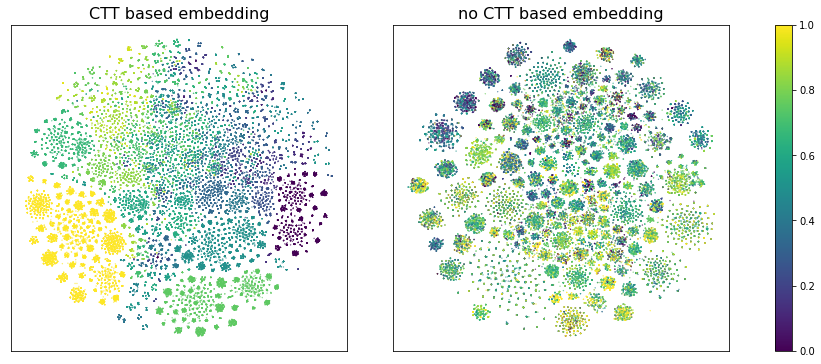

In [30]:
%%time
# tsne
import numpy as np
import pickle
from sklearn.manifold import TSNE

emb_dict_tsne = {
    'X_diff' : {
        'X_total' : [],
        'X_corr' : [],
    },
    'X_no_diff' : {
        'X_total' : [],
        'X_corr' : [],
    },
}
for trainer, emb_key in zip(trainer_list, emb_dict_tsne.keys()):
    emb_vec = np.array([emb_vec.tolist() for emb_vec in trainer.emb_vec])
    
    X_embedded = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec)
    X_embedded_corrected = TSNE(n_components=2, init='random', n_jobs=16).fit_transform(emb_vec[r_idxs == 1])
    
    emb_dict_tsne[emb_key]['X_total'] = X_embedded
    emb_dict_tsne[emb_key]['X_corr']  = X_embedded_corrected    
    
# with open('../model_records/emb_tsne.pickle', 'wb') as handle:
#     pickle.dump(emb_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

import matplotlib.cm as cm
import matplotlib.pyplot as plt

# figure
# total sample , diff 
plt.rcParams["figure.figsize"] = (14, 6)
emb_dict = emb_dict_tsne

# total_or_corr = 'X_corr'
total_or_corr = 'X_total'
color_idx = diff_color_idx if total_or_corr == 'X_total' else correct_diff_color_idx

fig, (ax1, ax2, cax) = plt.subplots(ncols = 3, gridspec_kw={"width_ratios":[1, 1, 0.05]})
axs = [ax1, ax2]

x_diff = axs[0].scatter(emb_dict['X_diff'][total_or_corr][:, 0], emb_dict['X_diff'][total_or_corr][:, 1], c = color_idx, s = .1)
axs[0].set_title('CTT based embedding', fontsize = 16)

x_no = axs[1].scatter(emb_dict['X_no_diff'][total_or_corr][:, 0], emb_dict['X_no_diff'][total_or_corr][:, 1], c = color_idx, s = .1)
axs[1].set_title('no CTT based embedding', fontsize = 16)

fig.colorbar(x_diff, cax=cax)

axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_xticks([])
axs[1].set_yticks([])

# plt.show()
# plt.savefig('../model_records/figure_4.pdf')